# Required installation and imports

In [2]:
!pip install jovian --upgrade --quiet
!pip install opendatasets --upgrade --quiet

In [3]:
project_name = 'covid-chest-xray'

In [4]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
import opendatasets as od
import jovian
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

# Download Data

### Dataset that has been used here is downloaded from [Kaggle](https://www.kaggle.com). You can get it [here](https://www.kaggle.com/pranavraikokte/covid19-image-dataset). 

### The dataset consists of Chest X-ray images of Covid-19 patients, Viral Pneumonia patients and normal persons. 

### Our moto is to develop a three class clssification deep learning model to predict if the person with the chest X-ray images have Covid-19, Viral Pneumonia or (s)he is fit and fine. 

In [5]:
dataset_url = 'https://www.kaggle.com/pranavraikokte/covid19-image-dataset'
od.download(dataset_url)

  0%|          | 0.00/158M [00:00<?, ?B/s]

100%|██████████| 158M/158M [00:02<00:00, 76.9MB/s]


In [6]:
data_dir = '/content/covid19-image-dataset/Covid19-dataset'

print(os.listdir(data_dir))
print(os.listdir(data_dir+'/train'))

['train', 'test']
['Normal', 'Viral Pneumonia', 'Covid']


# DataLoader and Batch initialization

### The data being a real life images needs some modificaion before putting into the deep neural network. 

### * Image size is not same throughout the whole dataset. Therefore all the images has been resized to 256 X 256 size using the Resize() function. 

### * Dataset being not enough large and also to maintain variation in training data, RandomHorizontalFlip is applied to use horizontal mirror image of given images. 




In [7]:
# stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
train_tfms = tt.Compose([tt.Resize((256,256)),
                         tt.RandomCrop(256, padding=4, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         # tt.Normalize(*stats, inplace=True)
                         ])

valid_tfms = tt.Compose([tt.Resize((256,256)),
                         tt.ToTensor(),
                         # tt.Normalize(*stats)
                         ])

In [8]:
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

### Batch size is something that needs some trial and error to check if it exceeds device memory and slowing down the training process or not. 

### Although it's a good practise to use batch_size as some power of two. 

### In this model, intially I started with 32 batch_size but that slowed down training extensively. But reducing batch size to 16 increased the training speed a lot.

In [9]:
batch_size = 16

In [10]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=3, pin_memory=True)

### In case, we are using some normalization on the data before training, this denormalize function is used to get back the image with real pizel values without any normalization.

### show_batch function basically takes a batch of data to show but as we have given a break statement, it shows the first image of the batch only. 

In [12]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return images*stds+means

def show_batch(dl):
    for images,labels in dl:
        fig, ax = plt.subplots(figsize=(12,12))
        ax.set_xticks([]);ax.set_yticks([])
        denorm_images = denormalize(images,*stats)
        ax.imshow(make_grid(images[:16], nrow=4).permute(1,2,0).clamp(0,1))
        # ax.imshow(make_grid(denorm_images[:16], nrow=4).permute(1,2,0).clamp(0,1))
        break

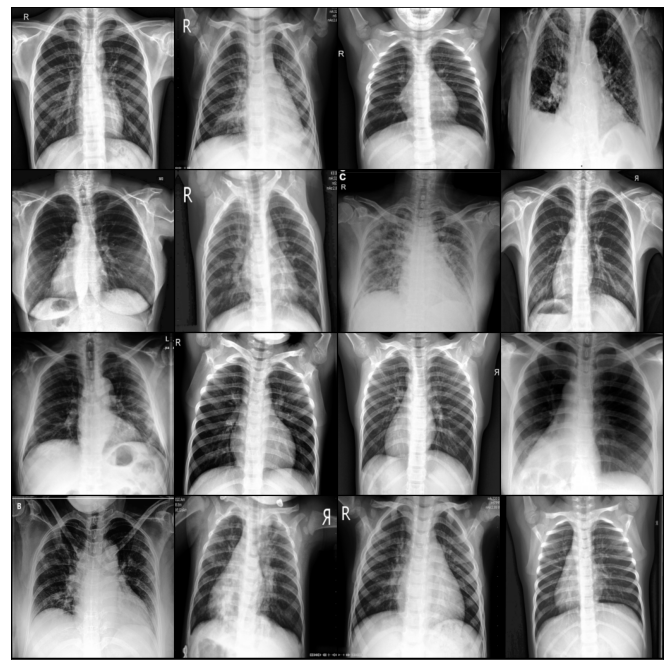

In [13]:
show_batch(train_dl)

# Helper functions for GPU

to_device function takes the data and device as parameter and shifts those data to the targetted device, which is the GPU here. 

In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [15]:
device = get_default_device()
device

device(type='cuda')

In [16]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

# Defining model and other required classes

## ImageClassificationBase class is moreover a general class that can be used generally for any image data model. training_step and validation_step functions apply the deep learning model, calculate and return the cost on training and validation batch respectively.

In [43]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

### This ResNet model has 9 layers in total. Takes batch of 3 channel input images of 256X256 image size. 

### The conv1, conv2, res1, conv3, conv4, res2 - all these convolution and residual layers converts the 3 channel 256X256 sized image to a 512 channel 4X4 feature map. 

### Finally another final maxpooling converts 4X4 feature map to 1X1.

### At the end a last linear layer convertes 512 dimensional flattened data to 3 dimensional data which is considered as prediction. 


### * *output dimensions of each layer has been written along with the code explicitely.*

In [44]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: 
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        # input: 3 X 256 X 256
        self.conv1 = conv_block(in_channels, 64) # out: 64 X 256 X 256
        self.conv2 = conv_block(64, 128, pool=True) # out: 128 X 64 X 64
        self.res1 = nn.Sequential(conv_block(128, 128), 
                                  conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True) # out: 256 X 16 X 16
        self.conv4 = conv_block(256, 512, pool=True) # out: 512 X 4 X 4
        self.res2 = nn.Sequential(conv_block(512, 512), 
                                  conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), # out: 512 X 1 X 1
                                        nn.Flatten(),  # out: 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))  # out: 3
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

### All information regarding each layer of the ResNet9 network has been printed below in details. 

In [45]:
model = to_device(ResNet9(3, 3), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [46]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# Traing and Optimization

In [47]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.32499998807907104, 'val_loss': 1.0998226404190063}]

In [48]:
epochs = 30
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [49]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00066, train_loss: 1.3361, val_loss: 4.9349, val_acc: 0.3250
Epoch [1], last_lr: 0.00147, train_loss: 0.3116, val_loss: 0.2190, val_acc: 0.9375
Epoch [2], last_lr: 0.00274, train_loss: 0.3041, val_loss: 0.1960, val_acc: 0.9000
Epoch [3], last_lr: 0.00431, train_loss: 0.5683, val_loss: 2.9096, val_acc: 0.6875
Epoch [4], last_lr: 0.00599, train_loss: 0.3040, val_loss: 3.6040, val_acc: 0.4375
Epoch [5], last_lr: 0.00757, train_loss: 0.4665, val_loss: 4.3738, val_acc: 0.3625
Epoch [6], last_lr: 0.00886, train_loss: 0.5396, val_loss: 4.1322, val_acc: 0.3500
Epoch [7], last_lr: 0.00971, train_loss: 0.6406, val_loss: 17.9416, val_acc: 0.4250
Epoch [8], last_lr: 0.01000, train_loss: 0.5934, val_loss: 6.2015, val_acc: 0.3500
Epoch [9], last_lr: 0.00994, train_loss: 0.7376, val_loss: 0.7437, val_acc: 0.7875
Epoch [10], last_lr: 0.00978, train_loss: 0.4444, val_loss: 0.4255, val_acc: 0.8250
Epoch [11], last_lr: 0.00950, train_loss: 1.5754, val_loss: 1.1421, val_acc: 0.8875
E

In [50]:
train_time='6:31'

# Plotting accuracy, cost, learning rate

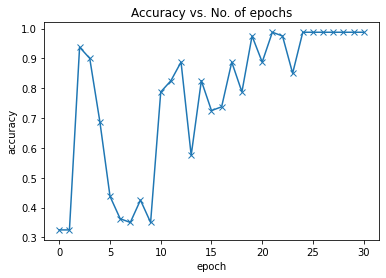

In [51]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

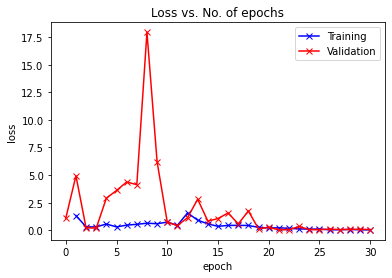

In [52]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

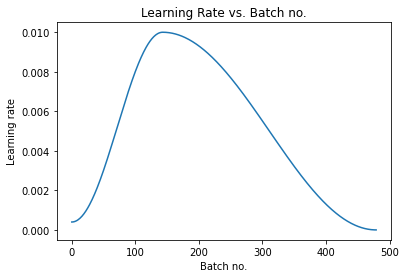

In [53]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');


plot_lrs(history)

# Predicting on individual images

In [55]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: Covid , Predicted: Covid


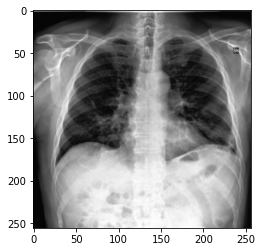

In [56]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Covid , Predicted: Covid


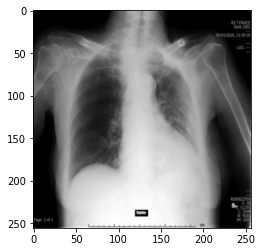

In [57]:
img, label = valid_ds[10]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Covid , Predicted: Covid


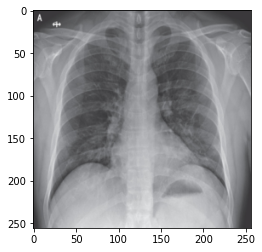

In [58]:
img, label = valid_ds[20]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Normal , Predicted: Normal


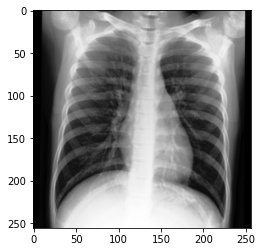

In [59]:
img, label = valid_ds[30]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Normal , Predicted: Normal


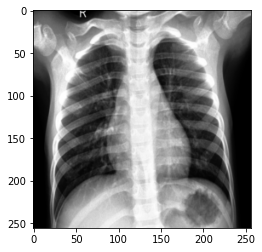

In [60]:
img, label = valid_ds[40]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Viral Pneumonia , Predicted: Viral Pneumonia


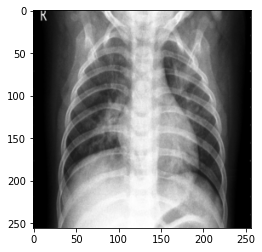

In [61]:
img, label = valid_ds[50]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Viral Pneumonia , Predicted: Viral Pneumonia


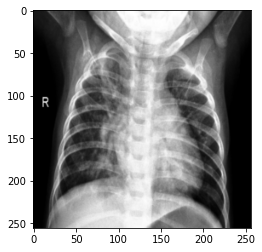

In [62]:
img, label = valid_ds[60]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

# Conclusion


## The validatioin accuracy being quite stable in the last five epochs (starting from 25th upto 30th) we can conclude that the model has reached the optimum model. 

## Although 98% accuracy is something really huge to claim and we can't do that exactly here. One of the reasons is that the dataset is not enough large to be trained on for a industry level deep neural network architecture.

## *So there is a scope of future improvement by training on more data.*

# Saving the trained model weights and other hyperparameters



In [71]:
torch.save(model.state_dict(), 'covid-chest-xray-resnet9.pth')

In [ ]:
jovian.reset()
jovian.log_hyperparams(arch='resnet9',
                       batch_size = batch_size, 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

In [69]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'],
                   time=train_time)

[jovian] Metrics logged.


In [73]:
jovian.commit(project=project_name, environment=None, outputs=['covid-chest-xray-resnet9.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/pinakisen-eenita/covid-chest-xray


'https://jovian.ai/pinakisen-eenita/covid-chest-xray'